In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten, TimeDistributed, GRU
from keras.layers.convolutional import Conv1D, MaxPooling1D


%matplotlib inline

pd.options.display.max_rows = 20

Using TensorFlow backend.


In [57]:
#load the csv
df = pd.read_csv('Air_Traffic_Passenger_Statistics.csv')
df

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,201903,Japan Airlines,JL,Japan Airlines,JL,International,Asia,Enplaned,Other,International,A,6995
1,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Enplaned,Other,International,A,12172
2,201903,Virgin Atlantic,VS,Virgin Atlantic,VS,International,Europe,Deplaned,Other,International,A,11496
3,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Enplaned,Other,International,G,7473
4,201903,United Airlines,UA,United Airlines,UA,International,Middle East,Deplaned,Other,International,G,6857
5,201903,United Airlines,UA,United Airlines,UA,International,Mexico,Enplaned,Other,Terminal 3,F,14982
6,201903,United Airlines,UA,United Airlines,UA,International,Mexico,Enplaned,Other,Terminal 3,E,9430
7,201903,United Airlines,UA,United Airlines,UA,International,Mexico,Enplaned,Other,International,G,2809
8,201903,United Airlines,UA,United Airlines,UA,International,Mexico,Deplaned,Other,International,G,25293
9,201903,United Airlines,UA,United Airlines,UA,International,Europe,Enplaned,Other,Terminal 3,F,207


In [58]:
#check no of rows and cols
df.shape

(20256, 12)

In [63]:
#get a short summary of datatypes and non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20193 entries, 0 to 20255
Data columns (total 12 columns):
Activity Period                20193 non-null int64
Operating Airline              20193 non-null object
Operating Airline IATA Code    20193 non-null object
Published Airline              20193 non-null object
Published Airline IATA Code    20193 non-null object
GEO Summary                    20193 non-null object
GEO Region                     20193 non-null object
Activity Type Code             20193 non-null object
Price Category Code            20193 non-null object
Terminal                       20193 non-null object
Boarding Area                  20193 non-null object
Passenger Count                20193 non-null int64
dtypes: int64(2), object(10)
memory usage: 2.0+ MB


In [60]:
#remove NAs
df.dropna(inplace=True)

In [64]:
#get summary for numerical values
df.describe()

#Activity Period actually is in the form of yyymm - so the year and the month, which we'll have to split later when plotting

,Activity Period,Passenger Count
count,20193.000000,20193.000000
mean,201223.867578,30037.951964
std,408.302261,61487.331168
min,200507.000000,1.000000
25%,200902.000000,5350.000000
50%,201210.000000,9179.000000
75%,201605.000000,20518.000000
max,201903.000000,659837.000000


In [81]:
# Selecting one airline's flights against time to see how the time series look
df_explore_virgin = df[(df['Operating Airline'] == 'Virgin Atlantic') &\
                       (df['Activity Type Code'] == 'Enplaned')]

In [ ]:
# Plot of passengers leaving SFO on Virgin Atlantic
plt.figure(figsize = (15,8))
plt.plot(df_explore_virgin['Activity Period'], df_explore_virgin['Passenger Count']);

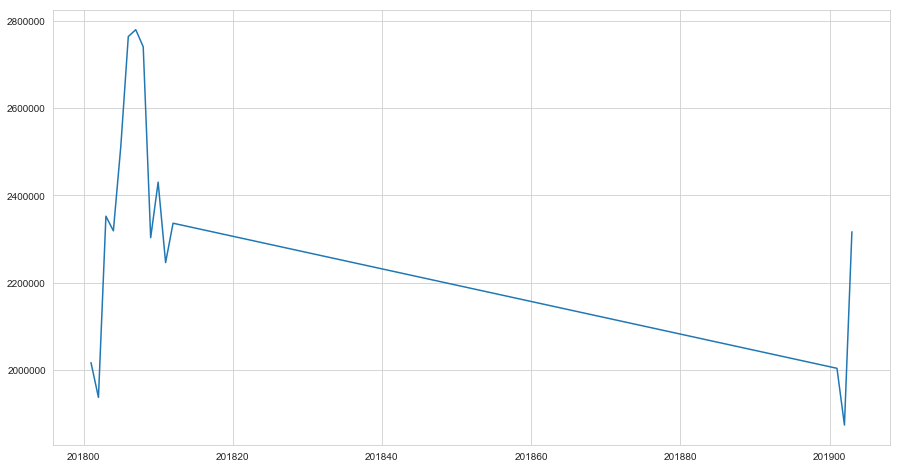

In [76]:
df_explore = df[df['Activity Type Code'] == 'Enplaned'].groupby('Activity Period').sum()

df_explore = df_explore[df_explore.index >= 201800]

# Zoomed-in version shows that it is interpreting the difference between "201812" and "201901" incorrectly
plt.figure(figsize = (15,8))
plt.plot(df_explore.index, df_explore['Passenger Count'])
#plt.savefig('img/data_cleaning_dates.png', bbox_inches = 'tight');

In [65]:
#for the catgeorical variables - the distributions of categorical variables
#compute and display a frequency table using the value_counts method. 
#A frequency table shows the frequency of each unique category of a categorical variable.

def count_unique(dataset, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(dataset[col].value_counts())

In [14]:
count_unique(df, df.columns)


For column Activity Period
201806    170
201805    165
201807    162
201808    159
201708    156
201809    155
201810    155
201709    154
201706    153
201710    153
         ... 
201111    110
201302    110
201409    110
200603    110
200604    110
200605    110
201407    109
200602    108
201303    108
201301    107
Name: Activity Period, Length: 165, dtype: int64

For column Operating Airline
United Airlines - Pre 07/01/2013    2154
United Airlines                     1892
SkyWest Airlines                    1297
Alaska Airlines                      929
Delta Air Lines                      467
Virgin America                       462
Air Canada                           438
Southwest Airlines                   417
American Airlines                    416
JetBlue Airways                      337
                                    ... 
Air Canada Jazz                       14
Independence Air                      10
World Airways                          3
Trego Dugan Aviation     

In [66]:
#for the categorical variables - display bar plots

def plot_bars(dataset, cols):
    for col in cols:
        fig = plt.figure(figsize=(10,20)) # define plot area
        ax = fig.gca() # define axis    
        counts = dataset[col].value_counts() # find the counts for each unique category
        counts.plot.bar(ax = ax, color = 'green') # Use the plot.bar method on the counts data frame
        ax.set_title('Frequency of each category: ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('number of observations')# Set text for y axis
        fig.autofmt_xdate()
        plt.show()

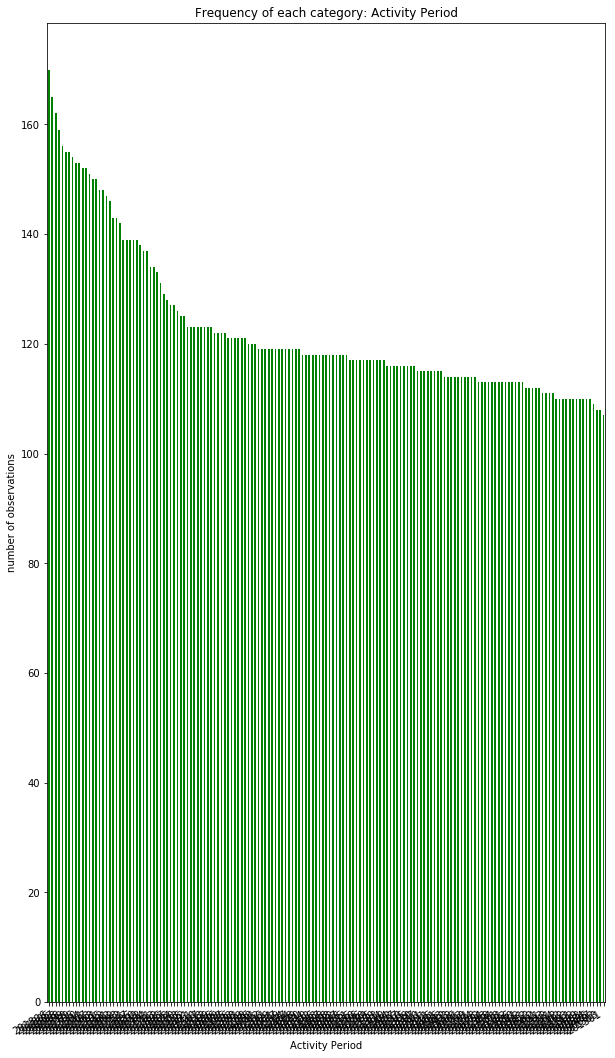

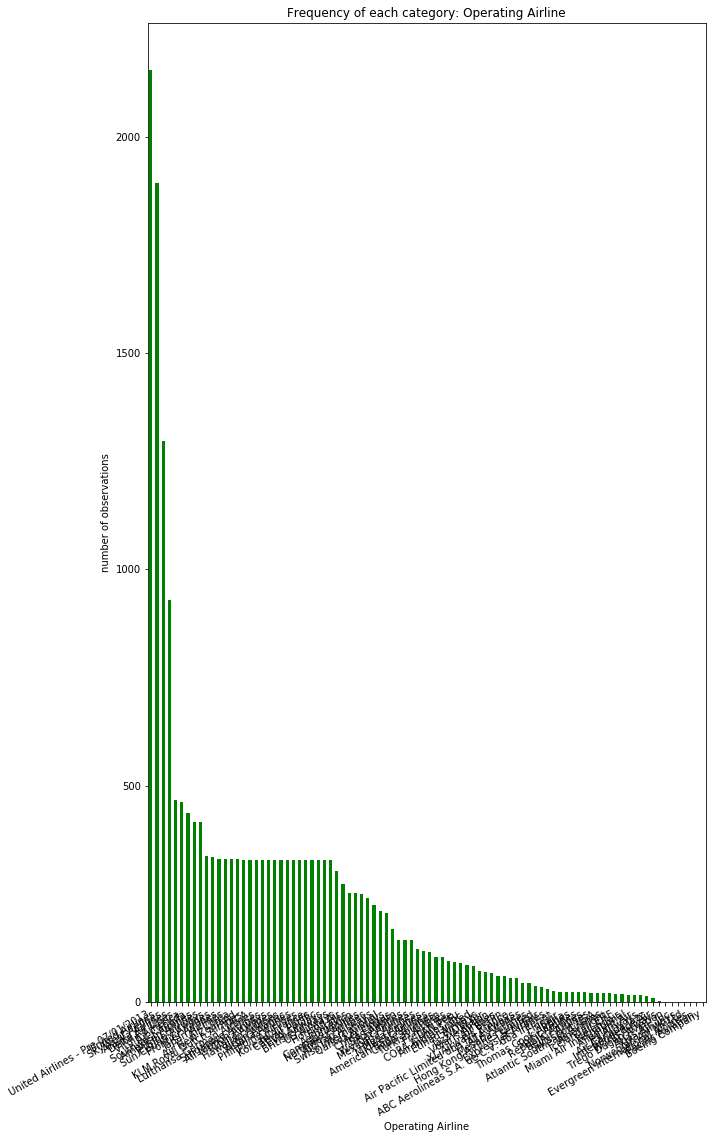

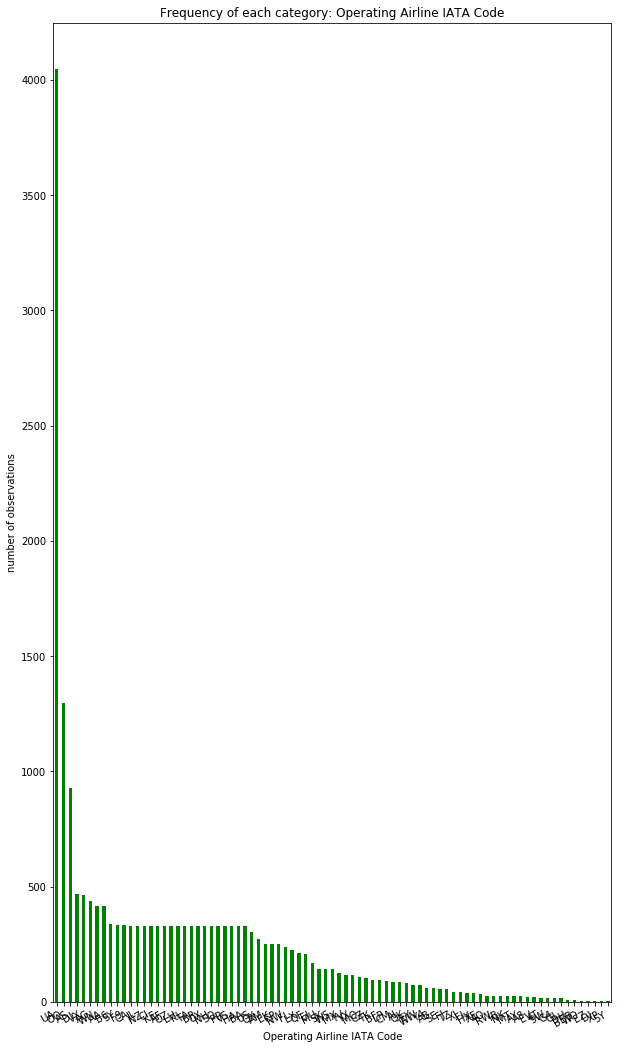

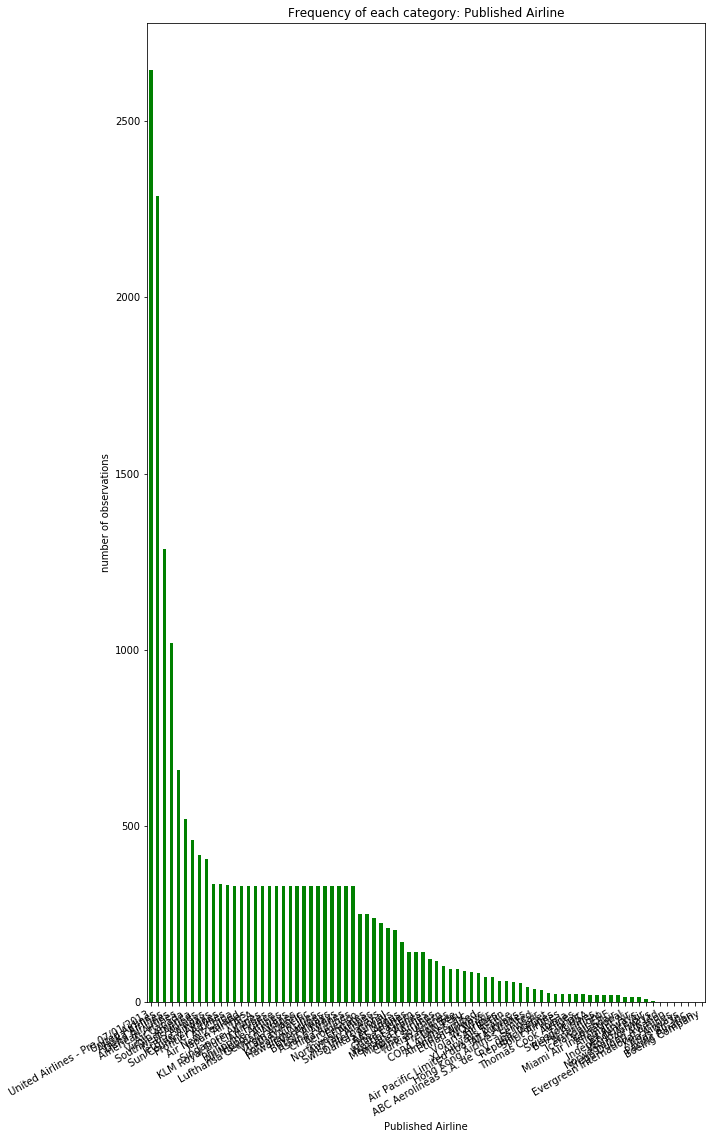

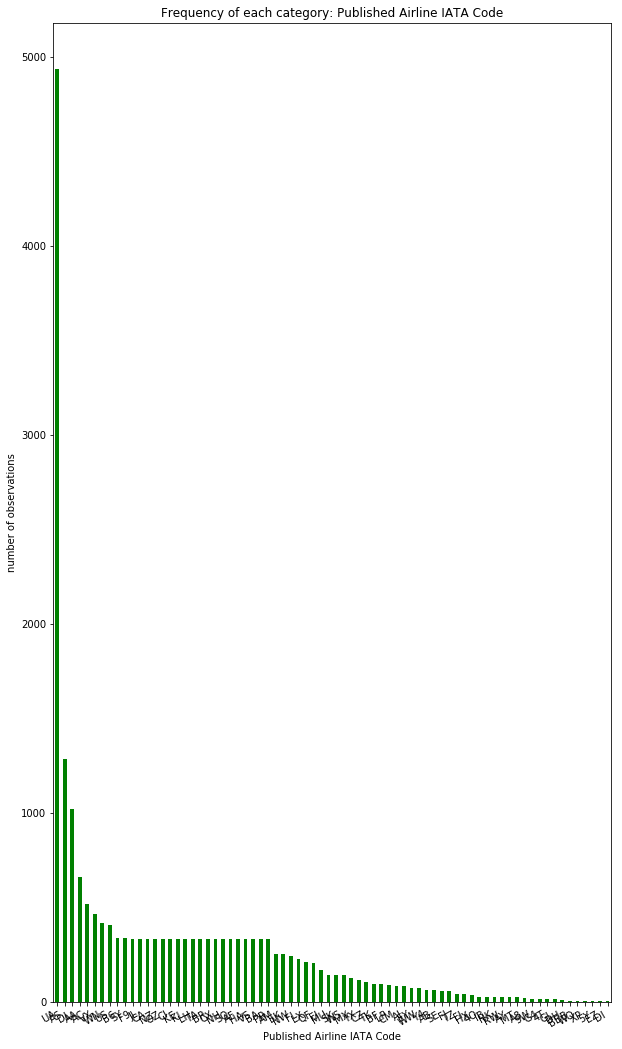

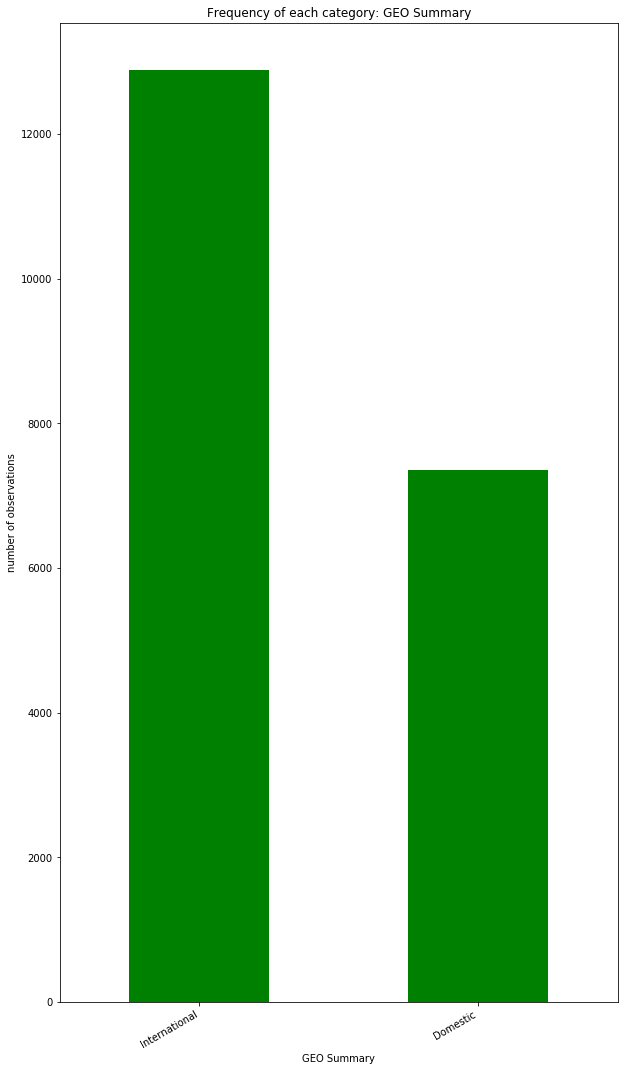

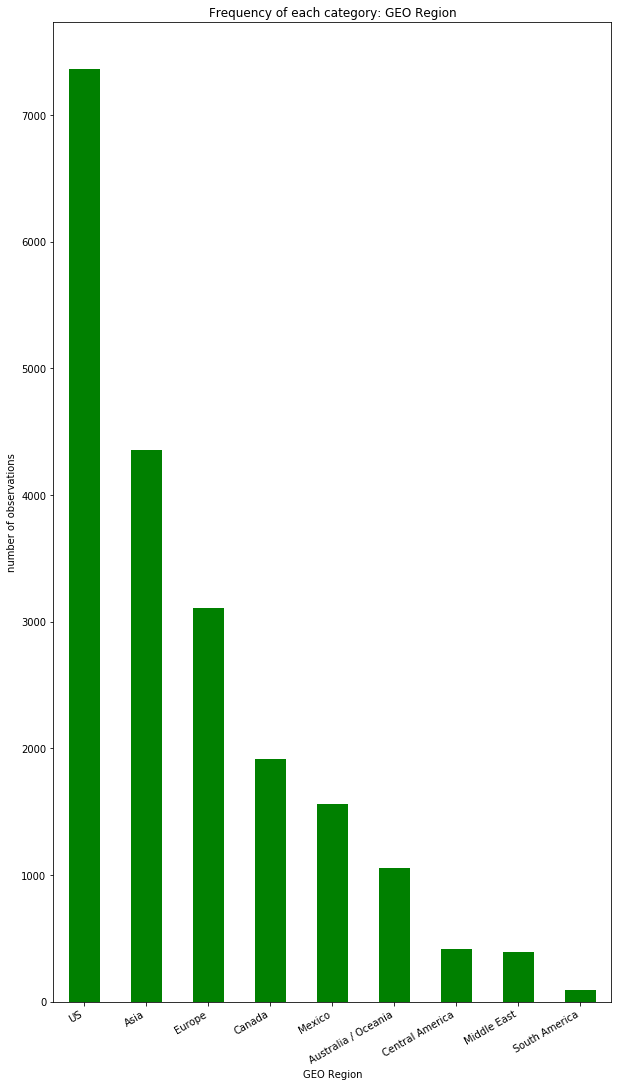

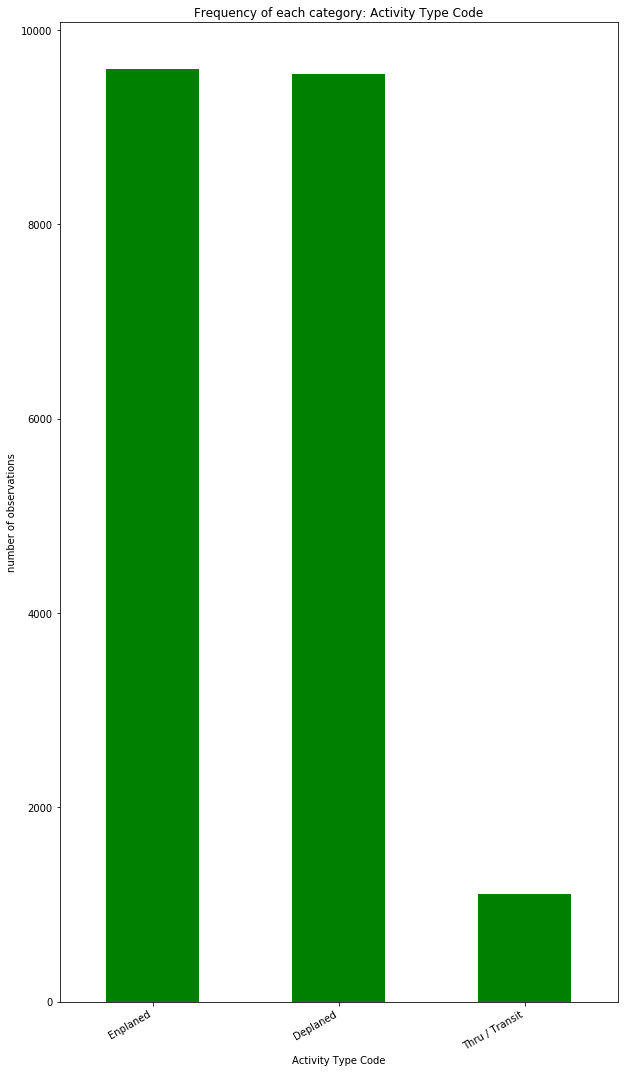

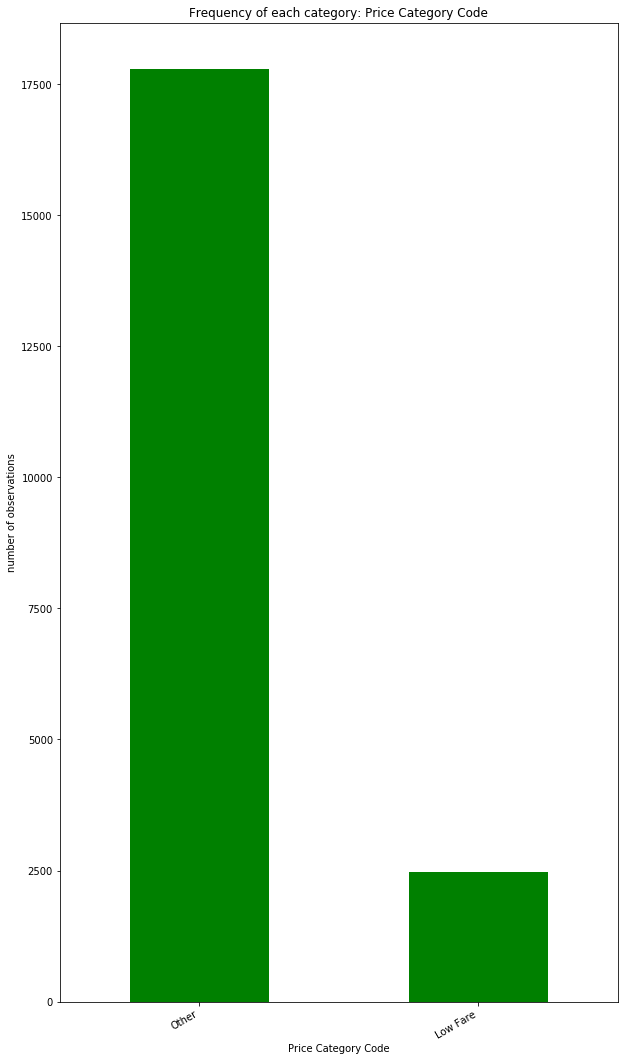

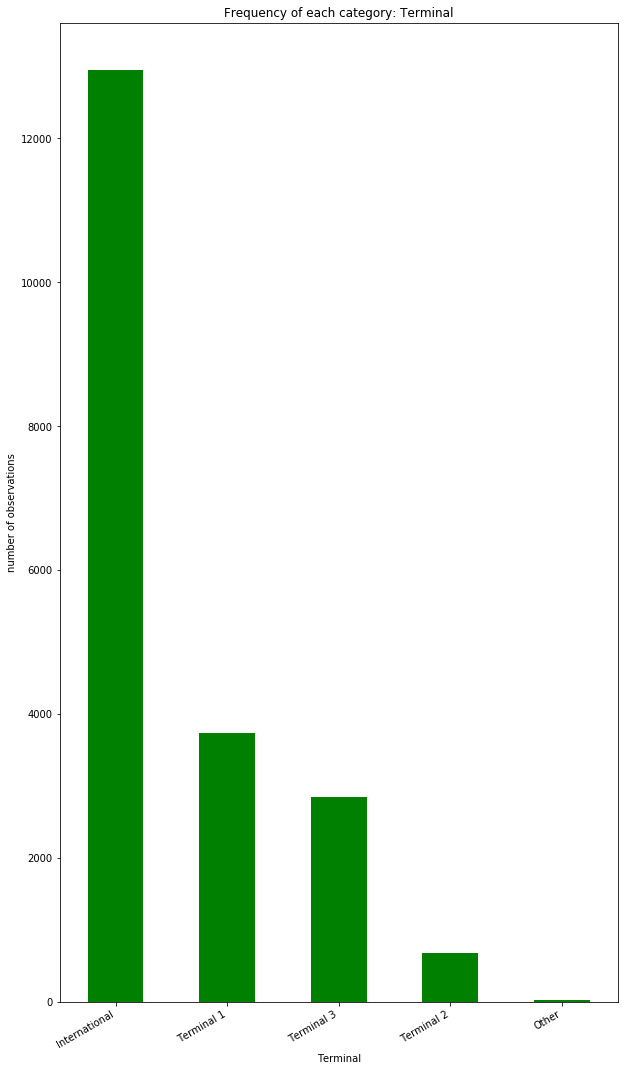

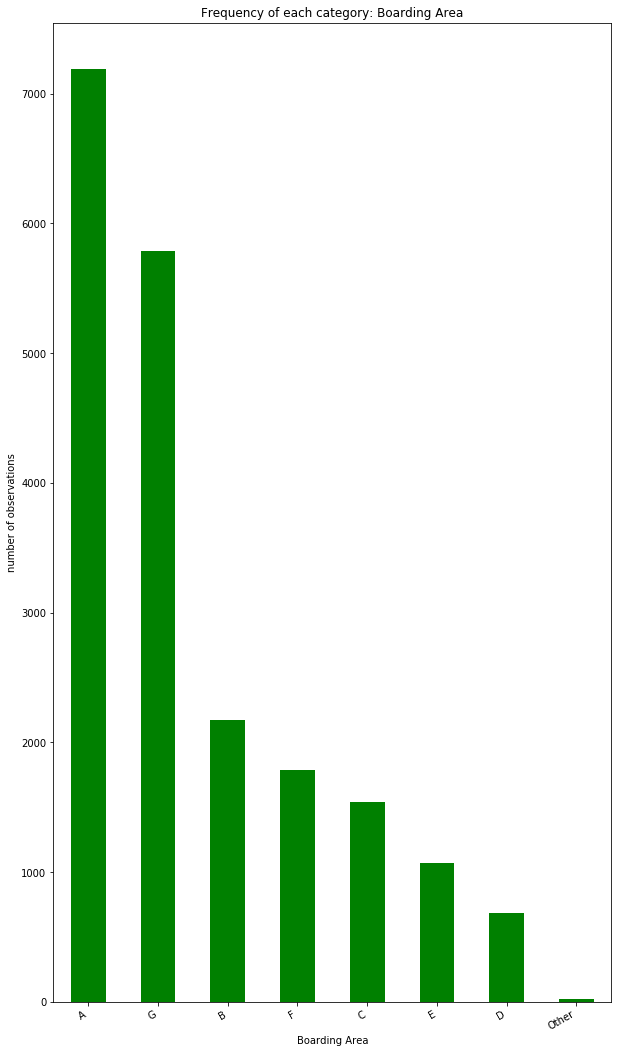

KeyboardInterrupt: 

In [31]:
plot_bars(df, df.columns)

In [67]:
#for the numeric variables - display histograms
def plot_histogram(dataset, cols, bins = 10):
    for col in cols:
        fig = plt.figure(figsize=(6,6)) # define plot area
        ax = fig.gca() # define axis    
        dataset[col].plot.hist(ax = ax, bins = bins) # Use the plot.hist method on subset of the data frame
        ax.set_title('Histogram of ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel('No_of_observations')# Set text for y axis
        plt.show()

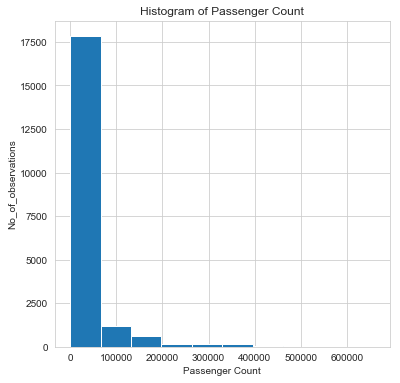

In [68]:
plot_histogram(df, df[['Passenger Count']])

In [69]:
#for the numerical columns there is the possibility to analyze a density histogram
def plot_density_hist(dataset, cols, bins = 10, hist = False):
    for col in cols:
        sns.set_style("whitegrid")
        sns.distplot(dataset[col], bins = bins, rug=True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('Frequency ')# Set text for y axis
        plt.show()

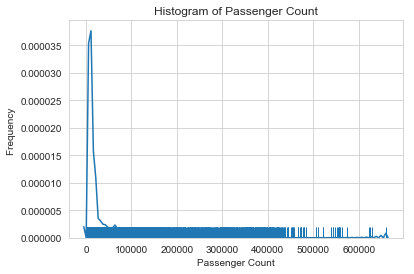

In [70]:
plot_density_hist(df, df[['Passenger Count']]) 

In [71]:
#forthe numerical values - some scatter plots
def plot_scatter(dataset, cols, col_y = 'Passenger Count'):
    for col in cols:
        fig = plt.figure(figsize=(7,6)) # define plot area
        ax = fig.gca() # define axis   
        dataset.plot.scatter(x = col, y = col_y, ax = ax)
        ax.set_title('Scatter plot of ' + col_y + ' vs. ' + col) # Give the plot a main title
        ax.set_xlabel(col) # Set text for the x axis
        ax.set_ylabel(col_y)# Set text for y axis
        plt.show()

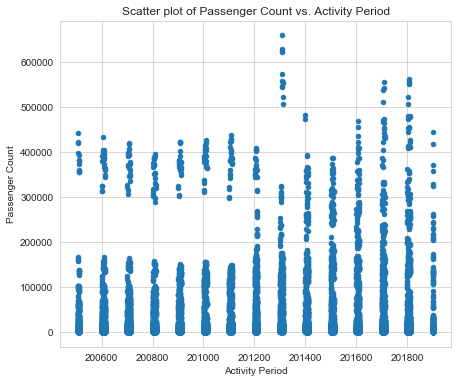

In [73]:
plot_scatter(df, df[['Activity Period']])